# Fashion mnist classification using different versions of LeNet

The goal of this notebook is to train Lenet network on fashion mnist dataset and evaluate performance.

We will test 4 versions of the network:

 - Original LeNet
 - LeNet with maxpooling instead of average pooling.
 - LeNet with ReLu and max pooling.
 
First all networks will be trained using the same optimizer settings and number of epochs so we can compare learning curves.
Then we will fine tune training settings for each network to see what they can achive.

This notebook is based on chapter 6 of dive to deep learning book.

## Dataset preparation

We will prepare training test and validatio datasets. No data agumentation will be used.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms as image_transforms
import numpy as np
import seaborn as sns
import torch
import torchvision
from torch import nn
from torchsummary import summary as model_summary
from sklearn.metrics import confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
transform = image_transforms.Compose([
    image_transforms.ToTensor(), # Outputs image in the range <0, 1>
    image_transforms.Normalize(0.5, 0.5), # Will shift to range <-1, 1>.
])

train_set = torchvision.datasets.FashionMNIST(root="../datasets", 
                                        train=True,
                                        download=True, 
                                        transform=transform)

test_set = torchvision.datasets.FashionMNIST(root="../datasets", 
                                       train=False,
                                       download=True, 
                                       transform=transform)

/home/krzys/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


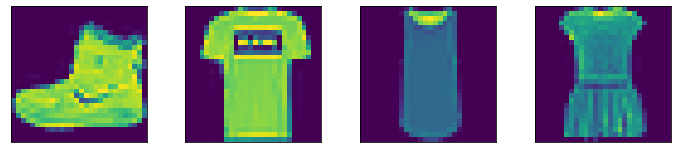

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(12,2.5))

for idx in range(4):
    axes[idx].imshow(train_set[idx][0][0])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

## Models

Now let's define all models.

In [4]:
def init_lenet(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        # Note: initalizing bias also seems to be important the network is supposed to be
        # retrained from scratch. There seem to be convergence problem if that is ommited.
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

def build_lenet(use_relu=False, use_maxpool=False):
    if use_relu:
        activation_fun = nn.ReLU
    else:
        activation_fun = nn.Sigmoid
        
    if use_maxpool:
        pooling = nn.MaxPool2d
    else:
        pooling = nn.AvgPool2d
    
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2),
        activation_fun(),
        pooling(kernel_size=2, stride=2),
        
        nn.Conv2d(6, 16, kernel_size=5),
        activation_fun(),
        pooling(kernel_size=2, stride=2),
        
        nn.Flatten(),
        
        nn.Linear(16 * 5 * 5, 120),
        activation_fun(),
        nn.Linear(120, 84),
        activation_fun(),
        nn.Linear(84, 10)
    )
    
    model = model.apply(init_lenet)
    
    return model

In [5]:
lenet_original = build_lenet()
_ = model_summary(lenet_original, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─Sigmoid: 1-2                           [-1, 6, 28, 28]           --
├─AvgPool2d: 1-3                         [-1, 6, 14, 14]           --
├─Conv2d: 1-4                            [-1, 16, 10, 10]          2,416
├─Sigmoid: 1-5                           [-1, 16, 10, 10]          --
├─AvgPool2d: 1-6                         [-1, 16, 5, 5]            --
├─Flatten: 1-7                           [-1, 400]                 --
├─Linear: 1-8                            [-1, 120]                 48,120
├─Sigmoid: 1-9                           [-1, 120]                 --
├─Linear: 1-10                           [-1, 84]                  10,164
├─Sigmoid: 1-11                          [-1, 84]                  --
├─Linear: 1-12                           [-1, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
To

In [6]:
lenet_with_relu = build_lenet(use_relu=True)
lenet_with_relu = lenet_with_relu.to(device)

In [7]:
lenet_with_maxpool = build_lenet(use_maxpool=True)
lenet_with_maxpool = lenet_with_maxpool.to(device)

In [8]:
lenet_with_relu_and_maxpool = build_lenet(use_relu=True, use_maxpool=True)
lenet_with_relu_and_maxpool = lenet_with_relu_and_maxpool.to(device)

## Training models

First we will train all models on the same optimizer with the same training settings so we can compare training curves.

In [9]:
def train_model(train_dataset, model, criterion, optim,
                device, val_split, batch_size, epochs, verbose=True):
    
    val_split = [int(len(train_dataset)*(1-val_split)), int(len(train_dataset)*val_split)]
    train, valid = torch.utils.data.random_split(train_dataset, val_split)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=4,
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, num_workers=4,
                                             shuffle=True)
    
    loss_history = []
    val_loss_history = []
    
    for epoch in range(epochs):
        losses = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optim.step()
            losses.append(loss.detach().cpu())
        
        train_loss = np.average(losses)
        loss_history.append(train_loss)
        
        losses = []
        for x, y in val_loader:
            with torch.no_grad():
                x = x.to(device)
                y = y.to(device)

                preds = model(x)
                loss = criterion(preds, y)
                
                losses.append(loss.cpu())
        val_loss = np.average(losses)
        val_loss_history.append(val_loss)
        
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, loss: {train_loss}, val_loss: {val_loss}")
        
    return {
        "loss": loss_history,
        "val_loss": val_loss_history
    } 

First let's compare learning curves. We wil train all models with the same settings and then plot validation and training losses.

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop
lr = 0.0005
epochs = 30
batch_size = 256
val_split = 0.2
verbose = False

In [11]:
optim = optimizer(lenet_original.parameters(), lr=lr)
history_original = train_model(train_set, lenet_original, loss, optim,
                    device, val_split, batch_size, epochs, verbose)

In [12]:
optim = optimizer(lenet_with_relu.parameters(), lr=lr)
history_relu = train_model(train_set, lenet_with_relu, loss, optim,
                    device, val_split, batch_size, epochs, verbose)

In [13]:
optim = optimizer(lenet_with_maxpool.parameters(), lr=lr)
history_maxpool = train_model(train_set, lenet_with_maxpool, loss, optim,
                    device, val_split, batch_size, epochs, verbose)

/home/krzys/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [14]:
optim = optimizer(lenet_with_relu_and_maxpool.parameters(), lr=lr)
history_relu_maxpool = train_model(train_set, lenet_with_relu_and_maxpool, loss, optim,
                    device, val_split, batch_size, epochs, verbose)

Here are all learning curves.

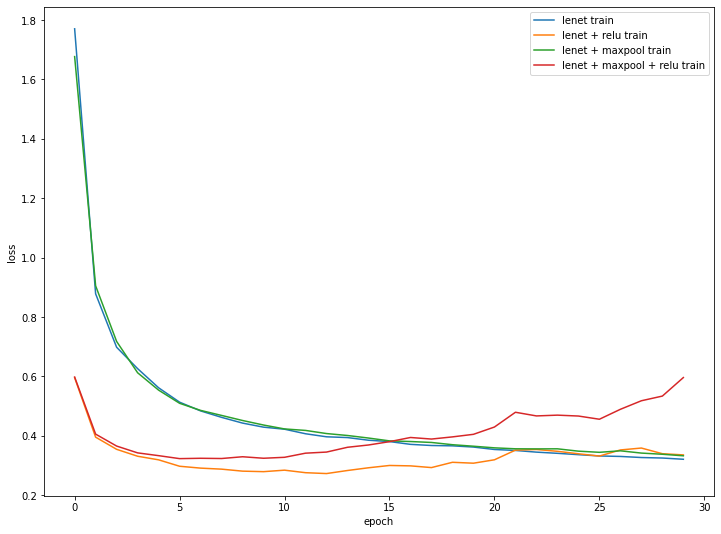

In [15]:
plt.figure(figsize=(12,9))

plt.plot(history_original["loss"], label="lenet train")
plt.plot(history_relu["loss"], label="lenet + relu train")
plt.plot(history_maxpool["loss"], label="lenet + maxpool train")
plt.plot(history_relu_maxpool["loss"], label="lenet + maxpool + relu train")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

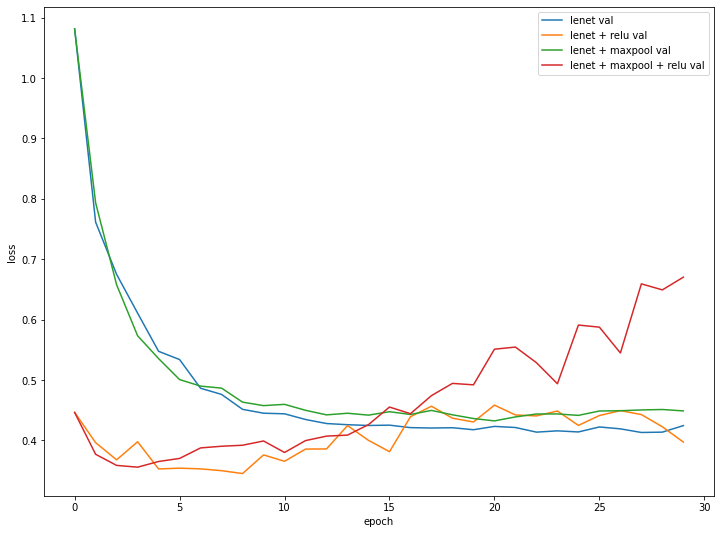

In [16]:
plt.figure(figsize=(12,9))
plt.plot(history_original["val_loss"], label="lenet val")
plt.plot(history_relu["val_loss"], label="lenet + relu val")
plt.plot(history_maxpool["val_loss"], label="lenet + maxpool val")
plt.plot(history_relu_maxpool["val_loss"], label="lenet + maxpool + relu val")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

It seems that  replacing average pooling with max pooling does increase performance but the highest performance gain is due to replacement of sigmoid with relu.

Also using relu activation makes network converge faster during training.

Now we will fine tune settings for each individual model so we get the best possible performance for each model.

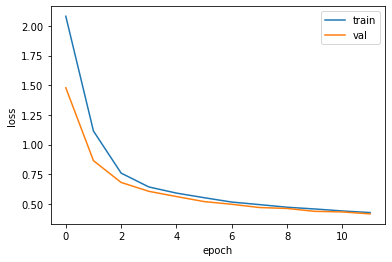

In [17]:
_ = lenet_original.apply(init_lenet)
optim = torch.optim.RMSprop(lenet_original.parameters(), lr=0.0005)
history = train_model(train_set, lenet_original, loss, optim,
                      device, val_split, batch_size, 12, False)

def plot_history(history):
    plt.plot(history["loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    
plot_history(history)

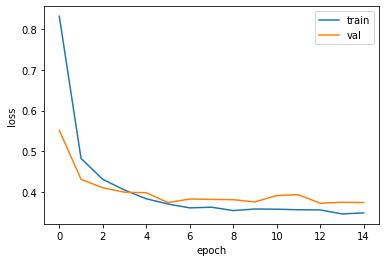

In [18]:
_ = lenet_with_relu.apply(init_lenet)
optim = torch.optim.RMSprop(lenet_with_relu.parameters(), lr=0.0005)
history = train_model(train_set, lenet_with_relu, loss, optim,
                      device, val_split, batch_size, 15, False)
plot_history(history)

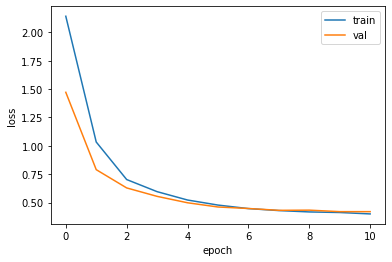

In [19]:
_ = lenet_with_maxpool.apply(init_lenet)
optim = torch.optim.RMSprop(lenet_with_maxpool.parameters(), lr=0.0005)
history = train_model(train_set, lenet_with_maxpool, loss, optim,
                     device, val_split, batch_size, 11, False)
plot_history(history)

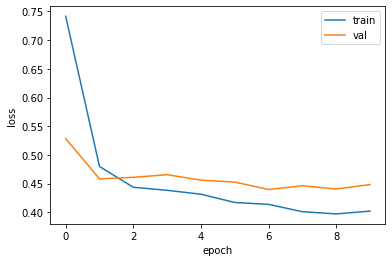

In [20]:
_ = lenet_with_relu_and_maxpool.apply(init_lenet)

optim = torch.optim.RMSprop(lenet_with_relu_and_maxpool.parameters(), lr=0.0005)
history = train_model(train_set, lenet_with_relu_and_maxpool, loss, optim,
                      device, val_split, batch_size, 10, False)
plot_history(history)

## Evaluation on test set

Now let's evaluate all models on a test set, compute accuracies and plot confusion matrix for each model.

In [21]:
def accuracy(y_hat, y):
    cmp = y_hat == y
    return float(cmp.sum())/len(y)

In [22]:
def get_predictions(model, data_loader, device):
    preds = np.array([])
    for x, y in test_loader:
        with torch.no_grad():
            x = x.to(device)
            pred = model(x)
            pred = pred.argmax(axis=1)
            pred = pred.cpu().numpy()
            preds = np.append(preds, pred)
    
    return preds.ravel().astype(int)

In [23]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, num_workers=4)
labels = np.array([])
for _, y in test_loader:
    labels = np.append(labels, y)
labels = np.ravel(labels).astype(int)

In [24]:
preds_original = get_predictions(lenet_original, test_loader, device)
accuracy(preds_original, labels)

0.8374

In [25]:
preds_with_relu = get_predictions(lenet_with_relu, test_loader, device)
accuracy(preds_with_relu, labels)

0.8599

In [26]:
preds_with_maxpool = get_predictions(lenet_with_maxpool, test_loader, device)
accuracy(preds_with_maxpool, labels)

0.8415

In [27]:
preds_with_relu_and_maxpool = get_predictions(lenet_with_relu_and_maxpool, test_loader, device)
accuracy(preds_with_relu_and_maxpool, labels)

0.8483

In [28]:
def plot_confusion_matrix(preds, labels, round_to=2):
    mat = confusion_matrix(labels, preds)
    mat =  mat.astype("float") / mat.sum(axis=1)[:, np.newaxis]
    mat = np.round(mat, round_to)
    
    fashion_mnist_labels = ["T-shirt/top", "Trouser",
                            "Pullover", "Dress",
                            "Coat", "Sandal",
                            "Shirt", "Sneaker",
                            "Bag", "Ankle Boot"]
    
    sns.heatmap(mat, annot=True, xticklabels=fashion_mnist_labels,
            yticklabels=fashion_mnist_labels)
    

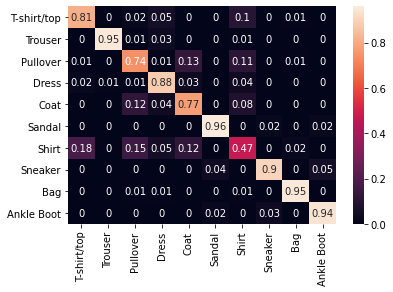

In [29]:
plot_confusion_matrix(preds_original, labels)

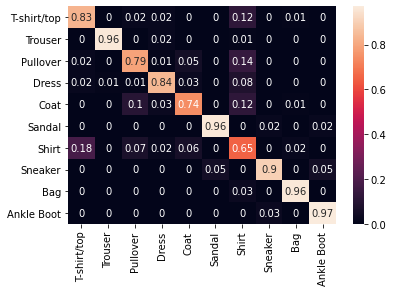

In [30]:
plot_confusion_matrix(preds_with_relu, labels)

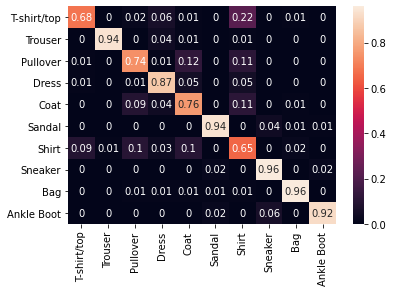

In [31]:
plot_confusion_matrix(preds_with_maxpool, labels)

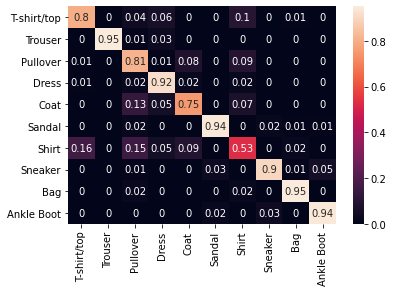

In [32]:
plot_confusion_matrix(preds_with_relu_and_maxpool, labels)

The best network seem to be the network with relu instead of sigmoid but performances are very similar.